In [1]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2023-12-03 17:41:47.810984: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 17:41:47.811065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 17:41:47.811095: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 17:41:47.820059: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 17:41:48.871188: W tensorflow/compiler/

2.14.0
CPU times: user 3.12 s, sys: 2.54 s, total: 5.66 s
Wall time: 2.75 s


In [2]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/criteo-uplift-v2.1.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [3]:
df_criteo_ori.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
%%time

sample = 0.15
random_state=20220720
df_criteo=df_criteo_ori.sample(frac=sample, random_state=random_state).reset_index(drop=True)
X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['visit'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
X_cali = X_cali[condition_cali]
T_cali = T_cali[condition_cali]
Y_visit_cali = Y_visit_cali[condition_cali]
Y_conv_cali = Y_conv_cali[condition_cali]

condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
X_test = X_test[condition_test]
T_test = T_test[condition_test]
Y_visit_test = Y_visit_test[condition_test]
Y_conv_test = Y_conv_test[condition_test]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

1467857 (1467857, 12) (524236, 12) 2096939 (104846, 12)
1467857 (1467857, 12) (327160, 12) 2096939 (65226, 12)
CPU times: user 1.42 s, sys: 45.5 ms, total: 1.46 s
Wall time: 1.46 s


In [5]:
count = 1

In [6]:
# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve



# TPM-CF method:

### Train model and predict

iteration =  1


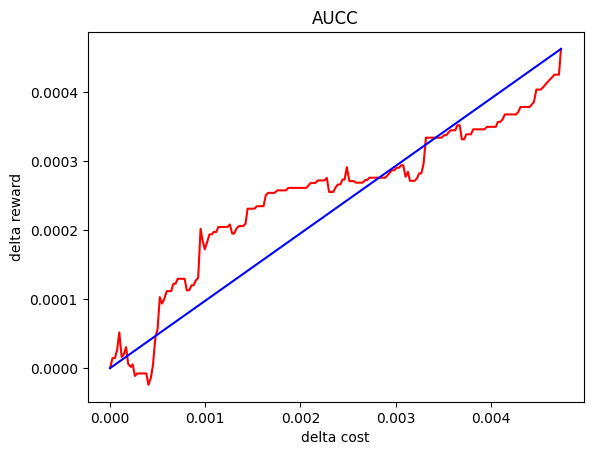

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0.000000,0.000000
1,0.000026,0.000014,268,49,7.893832,3.277111
2,0.000051,0.000014,290,52,7.451873,3.207982
3,0.000074,0.000027,706,123,4.080214,2.356450
4,0.000097,0.000052,824,142,3.706850,2.238583
...,...,...,...,...,...,...
196,0.004644,0.000422,128851,22979,0.089881,0.078698
197,0.004669,0.000425,133872,23842,0.083730,0.073164
198,0.004691,0.000425,138157,24595,0.078773,0.068594
199,0.004716,0.000425,153125,27192,0.063333,0.054481


AUCC =  0.5358008407497896




In [8]:
# GRF
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
import pickle
import sklearn 
import sklearn.metrics
from metric.Metric import *
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.uplift_model import *


grf_aucc_list = []

X_grf_train = X_train
T_grf_train = T_train.flatten()
Y_visit_grf_train = Y_visit_train.flatten()
Y_conv_grf_train = Y_conv_train.flatten()

X_grf_test = X_test
T_grf_test = T_test.flatten()
Y_visit_grf_test = Y_visit_test.flatten()
Y_conv_grf_test = Y_conv_test.flatten()

for i in range(count):
    
    print("iteration = ", i + 1)
    
    depth = 6
    min_samples_leaf = 100
    n_estimators = 128

    grf_random_state = 20220723 + i * 11
    
    # visit
    est_it = CausalForestDML(model_y=RandomForestClassifier(n_estimators=80, max_samples = 0.7, random_state=grf_random_state, max_depth=6, min_samples_leaf=500, n_jobs=32),
                          model_t=RandomForestClassifier(n_estimators=80, max_samples = 0.7, random_state=grf_random_state, max_depth=6, min_samples_leaf=500, n_jobs=32),
                          discrete_treatment=True,
                          cv=3,
                          n_estimators=n_estimators,
                          n_jobs=32,
                          max_depth=depth,
                          min_samples_leaf = min_samples_leaf,
                          random_state=grf_random_state)

    est_it.fit(Y_visit_grf_train, T_grf_train, X=X_grf_train, cache_values=True)
    
    model_file = "../model_file/uplift/criteo/final_model/grf/D_visit_CausalForestDML_{}.model".format(i + 1)
    
    fw = open(model_file, "wb")

    pickle.dump(est_it, fw)

    fw.close()
    
    grf_test_pre_visit = est_it.effect(X_grf_test)
    
    # conv
    est_it = CausalForestDML(model_y=RandomForestClassifier(n_estimators=160, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          model_t=RandomForestClassifier(n_estimators=160, max_samples = 0.7, random_state=grf_random_state, max_depth=12, min_samples_leaf=500, n_jobs=32),
                          discrete_treatment=True,
                          cv=3,
                          n_estimators=n_estimators,
                          n_jobs=32,
                          max_depth=depth,
                          min_samples_leaf = min_samples_leaf,
                          random_state=grf_random_state)

    est_it.fit(Y_conv_grf_train, T_grf_train, X=X_grf_train, cache_values=True)
    
    model_file = "../model_file/uplift/criteo/final_model/grf/D_conv_CausalForestDML_{}.model".format(i + 1)
    
    fw = open(model_file, "wb")

    pickle.dump(est_it, fw)

    fw.close()
    
    grf_test_pre_conv = est_it.effect(X_grf_test)
    
    # roi
    
    roi_grf_pre = grf_test_pre_conv / np.where(abs(grf_test_pre_visit) < 1e-6, 1e-6, grf_test_pre_visit)

    
    grf_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_grf_pre.flatten(), quantile=200)
    
    grf_aucc_list.append(grf_aucc)
    
    
    print("\n")
    

In [9]:
B_grf_aucc_list = get_aucc_cost_curve(grf_aucc_list)
print("aucc = ", np.sum(B_grf_aucc_list['delta_reward'].values) / (B_grf_aucc_list['delta_reward'].values[-1] * 201))
B_grf_aucc_list.to_csv("../figure/D_grf_aucc_list.csv")

aucc =  0.643851130137697
